# Project: Examining Women Education in Health Outcomes

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

I chose to examine the Gapminder's dataset. It includes indicators that denote economic, health and equality outcomes for most countries. I found it particularly fascinating because it can inform the areas we can change to improve the quality of life of people. 

For this analysis, I chose to examine women's education and how it affects contraceptive use and child mortality across the world. I believe that women's education is a major change lever and have seen throughout many studies how by raising it whole societies improve.

The two questions I asked myself were:
*   Could a higher equaliy in school enrollment translate to a higher contraceptive use?
*   Could a higher equality in school enrollment translate to less child deaths?

To do so I used the following variables::
* Gender Parity Index of School Enrollment
* Child Mortality (0-5 y/o child deaths per 1,000)
* Cotraceptive use for couples (15 - 49 y/o)


In [4]:
!pip install pandas==0.23.4
!pip install -U statsmodels
!pip install scipy --upgrade

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.9.0)
Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (1.3.0)


In [0]:
from scipy.special import factorial

In [8]:
# load libraries and set plot parameters
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline

ImportError: ignored

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [9]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ratio_of_girls_to_boys_in_primary_and_secondary_education_perc.csv to ratio_of_girls_to_boys_in_primary_and_secondary_education_perc (1).csv
Saving child_mortality_0_5_year_olds_dying_per_1000_born.csv to child_mortality_0_5_year_olds_dying_per_1000_born (1).csv
Saving contraceptive_use_percent_of_women_ages_15_49.csv to contraceptive_use_percent_of_women_ages_15_49 (1).csv
User uploaded file "ratio_of_girls_to_boys_in_primary_and_secondary_education_perc.csv" with length 33660 bytes
User uploaded file "child_mortality_0_5_year_olds_dying_per_1000_born.csv" with length 172828 bytes
User uploaded file "contraceptive_use_percent_of_women_ages_15_49.csv" with length 17139 bytes


In [11]:
# Reading files into Pandas Dataframe (CSV)

cmort = pd.read_csv('child_mortality_0_5_year_olds_dying_per_1000_born.csv')
contracept = pd.read_csv('contraceptive_use_percent_of_women_ages_15_49.csv')
edu_fem = pd.read_csv('ratio_of_girls_to_boys_in_primary_and_secondary_education_perc.csv')

edu_fem.head()

,country,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,0.167,0.161,0.161,0.169,0.167,0.174,0.181,0.193,0.199,NaN,NaN,0.243,0.484,NaN,0.471,0.477,0.532,NaN,0.501,NaN,NaN,0.537,NaN,0.361,0.430,0.472,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.544,0.406,0.549,0.575,0.570,0.590,0.614,0.630,0.668,0.674,0.660,0.659,0.652,NaN,0.645
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,0.931,NaN,0.932,0.937,0.926,0.922,0.933,0.959,0.950,0.939,0.939,0.941,0.954,0.952,0.943,0.944,1.010,1.030,0.995,0.971,0.975,0.958,NaN,0.956,0.963,0.974,NaN,NaN,0.966,0.964,0.971,0.982,0.984,1.000,0.987,0.979,0.970,0.957,0.946,0.943,0.945,NaN
2,Algeria,NaN,0.599,0.624,0.640,0.648,0.658,0.667,0.681,0.691,0.708,0.720,0.729,0.738,NaN,0.757,0.767,0.783,0.790,0.797,0.809,0.817,0.829,0.843,0.854,0.870,0.884,0.895,0.918,NaN,0.949,0.964,0.974,0.98,0.990,0.995,0.999,1.000,1.000,0.986,0.978,0.993,0.994,NaN,NaN,NaN,NaN,NaN,NaN
3,Andorra,NaN,NaN,NaN,NaN,NaN,1.150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,NaN,0.556,0.575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.811,0.777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819,0.810,0.765,0.621,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print(cmort.shape,contracept.shape,edu_fem.shape) 

(193, 220) (185, 58) (190, 49)




### Data Cleaning

In [13]:
# Melting dataframes into a tidy form
cmort_t = pd.melt(cmort, id_vars = 'country')
contracept_t = pd.melt(contracept, id_vars = 'country')
edu_fem_t = pd.melt(edu_fem, id_vars = 'country')

# Renaming columns
cmort_t.columns = ['country','year','child_mortality']
contracept_t.columns = ['country','year','contraceptive_use']
edu_fem_t.columns = ['country','year','female_education']

print(cmort_t.columns)
print(contracept_t.columns)
print(edu_fem_t.columns)

Index(['country', 'year', 'child_mortality'], dtype='object')
Index(['country', 'year', 'contraceptive_use'], dtype='object')
Index(['country', 'year', 'female_education'], dtype='object')


In [0]:
# Cleaning NA and Infinite values:
cmort_t.dropna(inplace = True)
contracept_t.dropna(inplace = True)
edu_fem_t.dropna(inplace = True)

In [0]:
# Data type cleaning function

def clean_datatype(df):
  df.year = df.year.astype(int)
  print(type(df.year[0]))

cmort_t.year = cmort_t.year.astype(int)
contracept_t.year = contracept_t.year.astype(int)
edu_fem_t.year = edu_fem_t.year.astype(int)

In [16]:
# Inner Join by Year and Country Name (Source: https://stackoverflow.com/questions/41815079/pandas-merge-join-two-data-frames-on-multiple-columns)

df_v1 = pd.merge(edu_fem_t,contracept_t,  how='left', left_on=['country','year'], right_on = ['country','year'])
df_v2 = pd.merge(edu_fem_t,cmort_t,  how='left', left_on=['country','year'], right_on = ['country','year'])

df_v1.dropna(inplace = True)
df_v2.dropna(inplace = True)

df_v1.info()
df_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814 entries, 23 to 5114
Data columns (total 4 columns):
country              814 non-null object
year                 814 non-null int64
female_education     814 non-null float64
contraceptive_use    814 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 31.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5106 entries, 0 to 5119
Data columns (total 4 columns):
country             5106 non-null object
year                5106 non-null int64
female_education    5106 non-null float64
child_mortality     5106 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 199.5+ KB


<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1: Could a higher equaliy in school enrollment translate to a higher contraceptive use?  

**Input:**
* School Enrollment Gender Parity Index
* Contraceptive Use

In [17]:
# Exploring dataset
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# Setting Seaborn Parameters
sns.set()
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size":8,
"ytick.major.size":8})
sns.axes_style("whitegrid") 

{'axes.axisbelow': True,
 'axes.edgecolor': '.8',
 'axes.facecolor': 'white',
 'axes.grid': True,
 'axes.labelcolor': '.15',
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': '.8',
 'grid.linestyle': '-',
 'image.cmap': 'rocket',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': '.15',
 'xtick.bottom': False,
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False}

### First, we're examining each variable individually

**Variable #1: School enrollment, primary and secondary (gross), gender parity index (GPI)**

Gender parity index for gross enrollment ratio in primary and secondary education is the ratio of girls to boys enrolled at primary and secondary levels in public and private schools.

**Development Relevance**: 
The Gender Parity Index (GPI) indicates parity between girls and boys. A GPI of less than 1 suggests girls are more disadvantaged than boys in learning opportunities and a GPI of greater than 1 suggests the other way around. Eliminating gender disparities in education would help increase the status and capabilities of women.

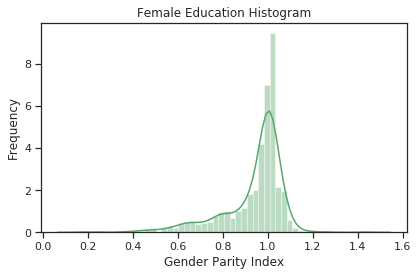

In [18]:
# Examining first variable through a histogram
sns.distplot(df_v1.female_education, color = "g")
plt.title("Female Education Histogram")
plt.xlabel("Gender Parity Index")
plt.ylabel("Frequency")
plt.tight_layout()

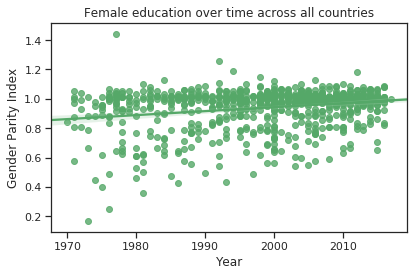

In [19]:
# Examining distribution of the values through a regression plot

sns.regplot(x = df_v1.year, y = df_v1.female_education, color = "g")
plt.title("Female education over time across all countries")
plt.xlabel("Year")
plt.ylabel("Gender Parity Index")
plt.tight_layout()

**Variable #2: Contraceptive prevalence, any methods (% of women ages 15-49)**

Contraceptive prevalence rate is the percentage of women who are practicing, or whose sexual partners are practicing, any form of contraception. It is usually measured for women ages 15-49 who are married or in union.

**Development Relevance**:
Reproductive health is a state of physical and mental well-being in relation to the reproductive system and its functions and processes. Means of achieving reproductive health include education and services during pregnancy and childbirth, safe and effective contraception, and prevention and treatment of sexually transmitted diseases. Complications of pregnancy and childbirth are the leading cause of death and disability among women of reproductive age in developing countries.

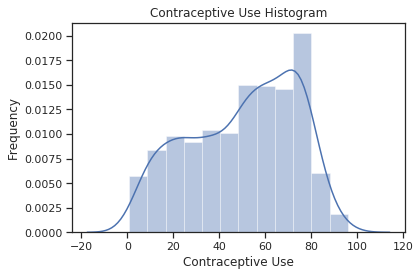

In [20]:
# Examining second variable through a histogram
sns.distplot(df_v1.contraceptive_use, color = "b")
plt.title("Contraceptive Use Histogram")
plt.xlabel("Contraceptive Use")
plt.ylabel("Frequency")
plt.tight_layout()

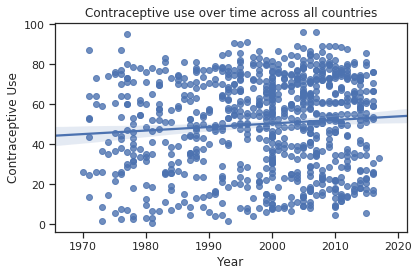

In [21]:
# Examining second variable through a regression plot
sns.regplot(x = df_v1.year, y = df_v1.contraceptive_use)
plt.title("Contraceptive use over time across all countries")
plt.xlabel("Year")
plt.ylabel("Contraceptive Use")
plt.tight_layout()

### Now we're going to see how they correlate with each other

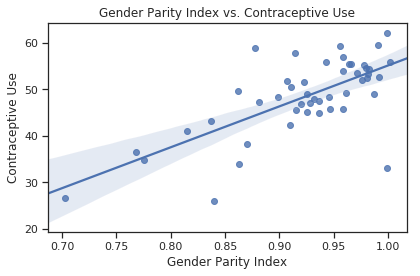

In [22]:
# Grouping the values into years
df_v1.describe()
df_v1.country.value_counts()
df_v1_yearly = df_v1.groupby(["year"],as_index = False).mean()

sns.regplot(x = df_v1_yearly.female_education,y = df_v1_yearly.contraceptive_use)
plt.title("Gender Parity Index vs. Contraceptive Use")
plt.xlabel("Gender Parity Index")
plt.ylabel("Contraceptive Use")
plt.tight_layout()

In [23]:
#Performing a linear regression analysis on the two variables
Y_1 = df_v1['contraceptive_use']
x_1 = df_v1['female_education']

model = sm.OLS(Y_1, x_1)
results = model.fit()
print(results.summary())

NameError: ignored

### Research Question 2: Could a higher equality in school enrollment translate to less child deaths?

**Input:**
* Contraceptive Use
* Child Mortality

### First let's examine each variable individually

**Variable #1: School enrollment, primary and secondary (gross), gender parity index (GPI)**

Gender parity index for gross enrollment ratio in primary and secondary education is the ratio of girls to boys enrolled at primary and secondary levels in public and private schools.

**Development Relevance**: 
The Gender Parity Index (GPI) indicates parity between girls and boys. A GPI of less than 1 suggests girls are more disadvantaged than boys in learning opportunities and a GPI of greater than 1 suggests the other way around. Eliminating gender disparities in education would help increase the status and capabilities of women.

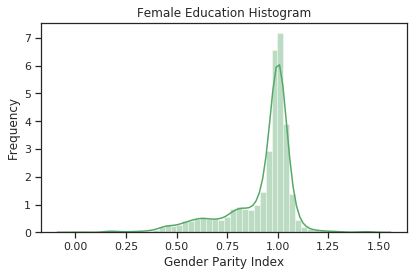

In [29]:
# Examining first variable through a histogram
sns.distplot(df_v2.female_education, color = "g")
plt.title("Female Education Histogram")
plt.xlabel("Gender Parity Index")
plt.ylabel("Frequency")
plt.tight_layout()

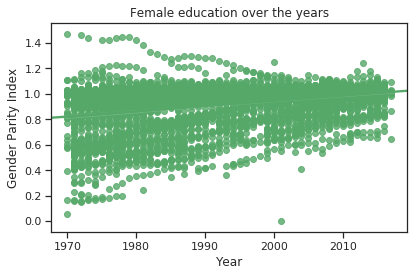

In [30]:
# Examining first variable through a regression plot
sns.regplot(x = df_v2.year , y = df_v2.female_education, color = "g")
plt.title("Female education over the years")
plt.xlabel("Year")
plt.ylabel("Gender Parity Index")
plt.tight_layout()

**Variable #2: Child Mortality (0-5 year olds dying per 1,000 born):**

Death of children under 5 years of age per 1000 live births


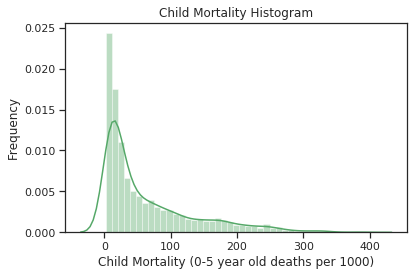

In [33]:
# Examining second variable: Child Mortality
sns.distplot(df_v2.child_mortality, color = "g")
plt.title("Child Mortality Histogram")
plt.xlabel("Child Mortality (0-5 year old deaths per 1000)")
plt.ylabel("Frequency")
plt.tight_layout()

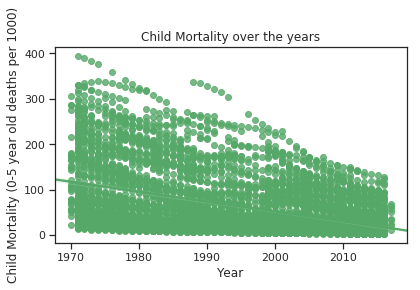

In [35]:
sns.regplot(x = df_v2.year, y = df_v2.child_mortality, color = "g")
plt.title("Child Mortality over the years")
plt.xlabel("Year")
plt.ylabel("Child Mortality (0-5 year old deaths per 1000)")
plt.tight_layout()

### Now we're going to see how they correlate with each other

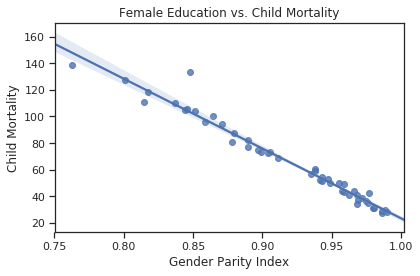

In [38]:
# Grouping the values into years
df_v2.describe()
df_v2.country.value_counts()
df_v2_yearly = df_v2.groupby(["year"],as_index = False).mean()

sns.regplot(x = df_v2_yearly.female_education,y = df_v2_yearly.child_mortality)
plt.title("Female Education vs. Child Mortality")
plt.xlabel("Gender Parity Index")
plt.ylabel("Child Mortality")
plt.tight_layout()

In [37]:
#Performing a linear regression analysis on the two variables
res2 = sm.OLS(df_v2['child_mortality'],df_v2['female_education']).fit()
print(res2.summary())

NameError: ignored

<a id='conclusions'></a>
## Conclusions

Overall I found women's education to have a strong positive correlation with contraceptive use and a negative moderate correlation with child mortality:

#### Research Question #1: Women's Education and Contraceptive Use

Women's education had a strong statistical correlation with an R^2 of more than 0.87 between the Gender Parity Index and the amount of couples who engage in contraceptive use. It is also notable to mention that both variables have increased throughout the years.

#### Research Question #2: Women's Education and Child Mortality

Women's education had a moderate statistical correlation with an R^2 of .3~ between the Gender Parity Index and the amount of child deaths for children aged from 0-5 . Child mortality has drastically decreased throughout the years and women's education has increased.


## Limitations

There are several limitations to the analysis, they are segmented into a) data cleaning limitations (e.g. missing values, null values, and the grouping of the countries by year) and b) data analysis limitations (e.g. difficulty of determining causality from the two variables for each research question)

### Data Cleansing Limitations:

Missing Values: All three of the datasets that were combined had 5%+ of missing values with respect to each other. After merging they only had 30-40% of overlapping values. This shouldn't have impacted the general analysis but is worth mentioning.

Country Grouping: For both of the research questions I grouped the countries by year. I understand they have a wide range (e.g. Ghana and Switzerland's child mortality), however, for the general trend this didn't affect greatly the 50+ year trendline.

### Data Analysis Limitations:

Determining Causality: While there's a strong (question #1) and moderate (question #2) trend for each analysis, there are many more confounding factors to finding causality between this variables. I could potentially do some additional analysis with other variables and find if there's an independent variable that stands out. 



In [0]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])